# Evaluation and Visualization of Generated Images

This notebook is designed to evaluate the quality of images generated by a neural network. We will extract features using Source Extraction Photometry (SEP) and evaluate image quality based off a variety of metrics. The results will be visualized to help assess the performance of the model.

## Setup

In this section, we import all the necessary libraries. These include:
- **PyTorch**: A deep learning framework for building and training neural networks.
- **SEP**: A tool for source extraction from astronomical images.
- **matplotlib**: For plotting and visualizing the data and results.
- **Other Libraries**: For image processing, statistical computations, and more.

In [3]:
import torch  # Deep learning framework
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional operations for neural networks
import torchvision.models as models  # Pre-trained models
from torchvision.models import inception_v3, Inception_V3_Weights  # Inception v3 model and weights
from torchvision import transforms  # For image transformations
from torchvision.transforms import Resize  # For image resizing

import os  # For file operations
import h5py  # For working with HDF5 files
import numpy as np  # Numerical computations
import pandas as pd  # For data manipulation and CSV handling

import matplotlib.pyplot as plt  # For plotting
from matplotlib.patches import Ellipse  # For drawing ellipses

import seaborn as sns  # For data visualization
from termcolor import colored  # For colored font
from tabulate import tabulate  # For tables

import sep  # Source Extraction Photometry
import scipy.ndimage as ndimage  # For image processing
from scipy.optimize import curve_fit  # For fitting functions
from scipy.linalg import sqrtm  # Matrix square root
from scipy.stats import entropy  # For computing entropy

import logging  # For logging messages
from tqdm import tqdm  # For progress bars
from concurrent.futures import ThreadPoolExecutor  # For parallel processing

from photutils.isophote import EllipseGeometry  # For fitting elliptical models
from photutils.isophote import Ellipse

from PIL import Image  # Image processing

# Custom modules
from modules import UNet_conditional_conv  # Custom UNet module
from data_manage import HDF5ImageGenerator  # Custom data loader

from scipy.stats import circmean
 


# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available


### Logging Setup

This block configures logging to capture detailed information in a log file while showing only errors in the console:

- **Clear Handlers:** Ensures previous handlers are removed to avoid duplicate logs.
- **File Logging:** Logs all messages (DEBUG and above) to `image_analysis.log`.
- **Console Logging:** Displays only errors (`ERROR` and above) in the console for less notebook clutter.
- **Root Logger:** Sets the root logger to capture all log levels and apply both handlers.

This setup allows for detailed logs in a file while keeping the console focused on critical issues.


In [4]:
# Clear existing logging handlers
if logging.getLogger('').hasHandlers():
    logging.getLogger('').handlers.clear()

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,  # Capture all levels of logs
    format='%(levelname)s: %(message)s',
    handlers=[
        logging.FileHandler("image_analysis.log", mode='w'),
        logging.StreamHandler()  # We'll adjust the console handler level below
    ]
)

# Get the root logger
logger = logging.getLogger()

# Adjust the console handler to log only errors and above
console_handler = logger.handlers[1]  # Assuming the second handler is StreamHandler
console_handler.setLevel(logging.ERROR)

# --- Redirect Warnings to Logging ---
logging.captureWarnings(True)

# --- Configure Third-party Loggers ---

# Configure the 'photutils' logger
photutils_logger = logging.getLogger('photutils')
photutils_logger.setLevel(logging.WARNING)  # Capture warnings and above from photutils

# Configure the 'astropy' logger (since photutils uses astropy)
astropy_logger = logging.getLogger('astropy')
astropy_logger.setLevel(logging.WARNING)  # Capture warnings and above from astropy

 

## Load Galaxy Images in Batches from PyTorch or HDF5 Files

The `load_images_in_batches` function is a generalized function that can load images in batches from either an HDF5 dataset or a list of PyTorch serialized (.pt) files. Here's a breakdown of what the function does:

1. The function takes the following parameters:
   - `source`: The data source. If `is_hdf5` is `True`, `source` should be an HDF5 dataset. If `is_hdf5` is `False`, `source` should be a list of file paths to .pt files.
   - `batch_size`: The number of images to load per batch.
   - `is_hdf5`: A boolean flag indicating whether the `source` is an HDF5 dataset or a list of file paths.

2. If `is_hdf5` is `True`, the function assumes the `source` is an HDF5 dataset. It iterates through the dataset in batches and directly yields the batches of images, without any additional processing.

3. If `is_hdf5` is `False`, the function assumes the `source` is a list of file paths to PyTorch serialized (.pt) files. It iterates through the files in batches, loading each individual image using `torch.load()`. If a batch contains any successfully loaded images, the function yields the batch. If a batch is empty, the function logs a warning message.

4. If any exception occurs during the batch loading process, the function logs an error message and returns `None`.

This function is useful when you need to load a large number of images, as it allows you to load them in smaller batches to save memory and improve performance. It can handle both HDF5 datasets and PyTorch serialized files, making it a versatile tool for working with image data.

In [5]:
def load_images_in_batches(source, batch_size=100, is_hdf5=False):
    """
    Loads images in batches from either an HDF5 dataset or a list of .pt files.

    Args:
        source (h5py.Dataset or list): The data source. 
            - If `is_hdf5` is True, `source` should be an HDF5 dataset.
            - If `is_hdf5` is False, `source` should be a list of file paths to .pt files.
        batch_size (int): Number of images per batch.
        is_hdf5 (bool): Flag indicating the type of source.

    Yields:
        Batch of images as a list or tensor.
    """
    try:
        if is_hdf5:
            # Loading from HDF5
            total_images = source.shape[0]
            for i in range(0, total_images, batch_size):
                batch = source[i:i + batch_size]
                yield batch  # Directly yield a batch from HDF5
        else:
            # Loading from .pt files using torch.load
            total_files = len(source)
            for i in range(0, total_files, batch_size):
                batch_files = source[i:i + batch_size]
                batch = []
                for file in batch_files:
                    try:
                        img = torch.load(file)
                        if img is not None:
                            batch.append(img)
                    except Exception as load_error:
                        logging.warning(f"Failed to load {file}: {load_error}")
                if batch:
                    yield batch  # Yield the batch if it's not empty
                else:
                    logging.warning(f"Batch {i // batch_size} is empty.")
    except Exception as e:
        logging.error(f"Error loading batches: {e}")
        return None

### Gaussian Smoothing Function

This function applies Gaussian smoothing (blurring) to an image. It uses `scipy`'s `gaussian_filter` to smooth the image with a specified `sigma` (default value is 1.5), which controls the amount of blurring. Gaussian smoothing helps in reducing noise and small-scale variations, making larger structures like galaxies stand out more clearly.
 

In [6]:
# Function to apply Gaussian smoothing using PyTorch on GPU or scipy for CPU
def apply_smoothing(image, sigma=1.5):
    return ndimage.gaussian_filter(image, sigma=sigma)


### Image Analysis with SEP and Metric Extraction

This function analyzes a single image (which will then be looped through the image dataset)  using the **Source Extraction and Photometry (SEP)** library, extracting key metrics such as the Sersic index, ellipticity, and semi-major/minor axes. Here’s how it works:

- **Image Conversion:** If the input image is a PyTorch tensor, it is first converted to a NumPy array. If the image has multiple channels, only the first channel is used.
  
- **Gaussian Smoothing (Optional):** If `apply_smoothing` is `True`, a Gaussian filter is applied to smooth the image, which helps reduce noise.

- **Background Subtraction:** The function estimates the image background using `sep.Background()` and subtracts it from the image to focus on the foreground objects.

- **Noise and Signal-to-Noise Check:** The function calculates the mean signal-to-noise ratio (SNR) and skips the image if the SNR is below a defined noise threshold.

- **Object Detection:** The `sep.extract()` method is used to detect objects in the background-subtracted image. If objects are found, the first object’s metrics are extracted:
  - `x` and `y`: Coordinates of the detected object.
  - `Semi-major Axis` and `Semi-minor Axis`: The dimensions of the object.
  - `Ellipticity`: Calculated as `1 - (semi_minor_axis / semi_major_axis)`.
  - `Orientation Angle`: The angle of the detected object.
  - `Isophotal Area`: The number of pixels in the object.

- **Redshift Inclusion:** If redshift data is provided, it is added to the result.

- **Ellipse Fitting & Sersic Index:** If valid, the function fits an elliptical model to the object using `EllipseGeometry`. The Sersic index is estimated (placeholder logic is used here) based on the object's ellipticity.

- **Return Result:** A dictionary containing all the extracted metrics (e.g., semi-major/minor axis, ellipticity, Sersic index, etc.) is returned.

This function combines multiple steps, including smoothing, background subtraction, object detection, and metric extraction, to analyze a galaxy image and output key structural properties.


In [7]:
# Function to analyze a single image with SEP and return the metrics 
def analyze_image_with_sep(image, redshift=None, apply_smoothing=True, sigma=1.5, noise_threshold=0.50):
    result = {}

    # If image is a PyTorch Tensor, convert it to a NumPy array
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # Use the first channel if the image has more than 1 channel
    if image.ndim == 3:
        image = image[0]

    # Convert image to float64 for SEP processing
    image = image.astype(np.float64)
    image = np.nan_to_num(image)

    # Apply Gaussian smoothing if required
    if apply_smoothing:
        image = ndimage.gaussian_filter(image, sigma=sigma)
    image = np.nan_to_num(image)

    try:
        bkg = sep.Background(image)
        image_sub = image - bkg
    except Exception as e:
        logging.warning(f"Error computing background or subtracting it: {e}")
        return None

    # Check if the image is empty or NaN after background subtraction
    if np.isnan(image_sub).all() or image_sub.size == 0:
        logging.warning("Image is all NaN or empty after background subtraction")
        return None

    # Add epsilon to avoid division by zero or infinite values
    epsilon = 1e-10
    mean_snr = np.mean(image_sub / (bkg.globalrms + epsilon))

    # Skip image if mean SNR is below the noise threshold
    if np.isnan(mean_snr) or mean_snr < noise_threshold:
        logging.debug(f"Mean SNR below threshold: {mean_snr}")
        return None

    try:
        objects = sep.extract(image_sub, 1.5, err=bkg.globalrms)
    except Exception as e:
        logging.warning(f"Error in SEP extraction: {e}")
        return None

    if len(objects) == 0:
        logging.warning("No objects found in image")
        return None

    # Extract metrics from the first object found
    obj = objects[0]
    x = obj['x']
    y = obj['y']
    semi_major_axis = obj['a']
    semi_minor_axis = obj['b']
    orientation_angle = obj['theta']
    isophotal_area = obj['npix']
    ellipticity = 1 - (semi_minor_axis / semi_major_axis)

    # Store the metrics in the result dictionary
    result['Semi-major Axis'] = float(semi_major_axis)
    result['Semi-minor Axis'] = float(semi_minor_axis)
    result['Ellipticity'] = float(ellipticity)
    result['Orientation Angle'] = float(orientation_angle)
    result['Isophotal Area'] = float(isophotal_area)

    # Include redshift in the result if available
    if redshift is not None:
        result['Redshift'] = float(redshift)

    # Fit ellipse geometry if valid
    if semi_major_axis > 0 and 0 <= ellipticity <= 1:
        try:
            geometry = EllipseGeometry(x0=x, y0=y, sma=semi_major_axis, eps=ellipticity, pa=orientation_angle)
            ellipse = Ellipse(image_sub, geometry)
            isophote_list = ellipse.fit_image()
            # Estimate Sersic index (placeholder logic)
            sersic_n = np.log(2) / np.log((1 + ellipticity) / (1 - ellipticity))
            result['Sersic Index'] = float(sersic_n)
        except Exception as e:
            logging.warning(f"Error fitting ellipse or calculating Sersic index: {e}")
            result['Sersic Index'] = np.nan

    return result


## Incrementally Save Results to a CSV File

The `save_results_to_csv` function is used to save a list of result dictionaries to a CSV file. It ensures the results are in the correct format, creates the necessary directory structure, and appends the data to the CSV file if it already exists. Here's a breakdown of what the function does:

1. The function takes two parameters:
   - `results`: A list of dictionaries, where each dictionary represents the results of a single execution.
   - `csv_path`: The file path where the CSV file should be saved.

2. The function first checks if the `results` list is empty. If so, it logs a warning message and returns.

3. The function then iterates through the `results` list and creates a new list called `cleaned_results`. For each result dictionary, it performs the following actions:
   - If the value of a key is a PyTorch tensor, it converts the tensor to a scalar value using the `item()` method.
   - If the value of a key is a dictionary, it logs a warning message and converts the dictionary to a string.
   - For all other value types, it keeps the value as is.

4. The function then creates a Pandas DataFrame from the `cleaned_results` list.

5. It ensures that the directory structure for the `csv_path` exists by creating the necessary directories using `os.makedirs()`.

6. It determines whether to write the header row to the CSV file by checking if the file already exists and has content. If the file is empty or does not exist, the header is written.

7. Finally, the function saves the DataFrame to the CSV file using `df.to_csv()`. If the file already exists, it appends the new data to the existing file; otherwise, it creates a new file.

8. The function logs an informational message indicating that the results have been saved to the specified CSV file.

This function is useful when you need to save the results of multiple executions or experiments to a CSV file incrementally, without overwriting the existing data.

In [8]:
# Save results to CSV incrementally (append mode)
def save_results_to_csv(results, csv_path):
    # Ensure results are not empty
    if not results:
        logging.warning("No results to save.")
        return

    # Ensure each entry in results is a dictionary with native types
    cleaned_results = []
    for result in results:
        cleaned_result = {}
        for key, value in result.items():
            if isinstance(value, torch.Tensor):
                # Convert Tensors to scalars
                cleaned_result[key] = value.item()
            elif isinstance(value, dict):
                logging.warning(f"Unexpected dict found in results for key '{key}'")
                cleaned_result[key] = str(value)  # Convert dict to string
            else:
                cleaned_result[key] = value
        cleaned_results.append(cleaned_result)

    # Create DataFrame
    df = pd.DataFrame(cleaned_results)

    # Ensure directory exists
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)

    # Determine whether to write the header
    if not os.path.exists(csv_path) or os.path.getsize(csv_path) == 0:
        header = True
    else:
        header = False

    # Save to CSV
    mode = 'a' if os.path.exists(csv_path) else 'w'  # Append if file exists
    df.to_csv(csv_path, index=False, mode=mode, header=header)

    logging.info(f"Results saved to {csv_path}")


## Main Code Execution for Testing Images

This code block is responsible for the main execution of processing the testing images and saving the results to a CSV file. Here's a breakdown of what it does:

**Configurable Parameters:**
- `testing_hdf5_path`: The file path to the HDF5 file containing the testing images and redshift data.
- `batch_size`: The number of images to process in each batch.
- `max_images`: The maximum number of images to process. This should be set to the same value when processing both testing and generated images.
- `csv_path`: The file path to the CSV file where the results will be saved.

1. Checks if the `csv_path` file already exists, and if so, deletes it. This ensures a clean start for the new results.

2. Opens the HDF5 file using `h5py.File()` and retrieves the `image` and `specz_redshift` datasets.

3. Determines the number of images to process, which is the minimum of the total images in the dataset and the `max_images` parameter.

4. Uses a `tqdm` progress bar to display the progress of processing the images.

5. Iterates through the images in batches of `batch_size`, processing each batch as follows:
   - Extracts the image and redshift data for the current batch.
   - Processes each image in the batch using the `analyze_image_with_sep()` function 
   - Appends the results of the image analysis to the `batch_results` list, adding an `Image Index` key to each result.
   - Updates the progress bar.

6. After each batch is processed, the `batch_results` list is saved to the `csv_path` file using the `save_results_to_csv()` function.

 
This code block is the main entry point for processing the testing images, leveraging the HDF5 dataset and the `load_images_in_batches()` and `save_results_to_csv()` functions to efficiently process and save the results.

In [9]:
#NOTE: For best analysis, set max_images to the same number when processing testing and generated imgaes


# Main code execution for testing images
testing_hdf5_path = '/shared/astrodata/5x64x64_testing_with_morphology.hdf5'
batch_size = 100
max_images = 500

# Delete the testing images CSV file if it exists
csv_path = 'output/testing_images_metrics.csv'
if os.path.exists(csv_path):
    os.remove(csv_path)

# Load HDF5 images and redshift data
with h5py.File(testing_hdf5_path, 'r') as f:
    images_dataset = f['image']
    redshift_dataset = f['specz_redshift']

    num_images = min(images_dataset.shape[0], max_images)

    with tqdm(total=num_images, desc="Processing Testing HDF5 images") as pbar:
        for i in range(0, num_images, batch_size):
            image_batch = images_dataset[i:i + batch_size]
            redshift_batch = redshift_dataset[i:i + batch_size]

            batch_results = []

            for j, image in enumerate(image_batch):
                try:
                    result = analyze_image_with_sep(image, redshift=redshift_batch[j])
                    if result:
                        result['Image Index'] = i + j
                        batch_results.append(result)
                except Exception as e:
                    logging.error(f"Error processing image {i + j}: {str(e)}")

                pbar.update(1)

            # Save batch results after each batch
            save_results_to_csv(batch_results, csv_path)

Processing Testing HDF5 images: 100%|██████████| 500/500 [02:24<00:00,  3.46it/s]


### Main Code Execution for Generated Images

Overall, this code behaves almost identically to the previous block but operates on **generated images** instead of **testing images**, storing results in a different CSV file.


In [10]:
# Main code execution for generated images
generated_hdf5_path = './ddpm_5x64x64_testing.hdf5'
batch_size = 100
max_images = 500

# Delete the generated images CSV file if it exists
csv_path = 'output/generated_images_metrics.csv'
if os.path.exists(csv_path):
    os.remove(csv_path)

# Load HDF5 images and redshift data
with h5py.File(generated_hdf5_path, 'r') as f:
    images_dataset = f['image']   
    redshift_dataset = f['specz_redshift']   

    num_images = min(images_dataset.shape[0], max_images)

    with tqdm(total=num_images, desc="Processing Generated HDF5 Images") as pbar:
        for i in range(0, num_images, batch_size):
            image_batch = images_dataset[i:i + batch_size]
            redshift_batch = redshift_dataset[i:i + batch_size]

            batch_results = []

            for j, image in enumerate(image_batch):
                try:
                    result = analyze_image_with_sep(image, redshift=redshift_batch[j])
                    if result:
                        result['Image Index'] = i + j
                        batch_results.append(result)
                except Exception as e:
                    logging.error(f"Error processing image {i + j}: {str(e)}")

                pbar.update(1)

            # Save batch results after each batch
            save_results_to_csv(batch_results, csv_path)

Processing Generated HDF5 Images: 100%|██████████| 500/500 [02:02<00:00,  4.07it/s]


### Calculate Averages from CSV

This function, `calculate_averages_from_csv`, summarizes the results of image analysis by calculating the average values of key metrics (e.g., Sersic index, ellipticity) from the Testing and Generated CSV files produced in previous steps. 

#### Context:
- In earlier steps, metrics from individual galaxy images were extracted using the `analyze_image_with_sep` function and saved to CSV files.
- This function reads the CSV file, computes the averages for selected metrics, and returns them as a dictionary, providing a summary of the dataset.

#### Functionality:
- The CSV file is read into a Pandas DataFrame.
- The function calculates the mean of metrics like `Semi-major Axis`, `Ellipticity`, `Sersic Index`, etc., ignoring `NaN` values.
- If a metric is missing, the function sets the average to `None` and prints a message.

#### Purpose:
By averaging these metrics, the function provides an overall picture of the dataset’s characteristics, allowing for easy comparison between real and generated galaxy images.


In [11]:
# Function to calculate circular mean specifically for orientation angles
def calculate_circular_mean(data):
    return circmean(data, high=np.pi/2, low=-np.pi/2)

# Updated function to calculate linear averages, excluding orientation angle from the main averages
def calculate_averages_from_csv(csv_file_path):
    df = pd.read_csv(csv_file_path)
    metrics = ['Semi-major Axis', 'Semi-minor Axis', 'Ellipticity', 'Isophotal Area', 'Sersic Index']
    averages = {metric: df[metric].mean() for metric in metrics if metric in df.columns}
    
    # Calculate circular mean separately for orientation angle
    if 'Orientation Angle' in df.columns:
        orientation_avg = calculate_circular_mean(df['Orientation Angle'].dropna())
    else:
        orientation_avg = None
    
    return averages, orientation_avg


### Plotting Comparison of Averages Between Generated and Testing Images

This code compares the average values of key metrics between **generated** and **testing** images, using data from CSV files.

- **Load Averages:** The function `calculate_averages_from_csv` is used to load the average values for both generated and testing images from their respective CSV files.
- **Metrics Comparison:** A list of metrics (`Semi-major Axis`, `Ellipticity`, `Sersic Index`, etc.) is defined, and the corresponding average values are extracted for plotting.
- **Plotting:** 
  - Subplots are created to display a bar chart for each metric, comparing the average values between the **generated** and **testing** images.
  - The plots are arranged in a 2x3 grid, with labels and titles for each metric.
- **Visualization:** The final plot provides a clear visual comparison of how well the generated images match the testing images across these metrics.


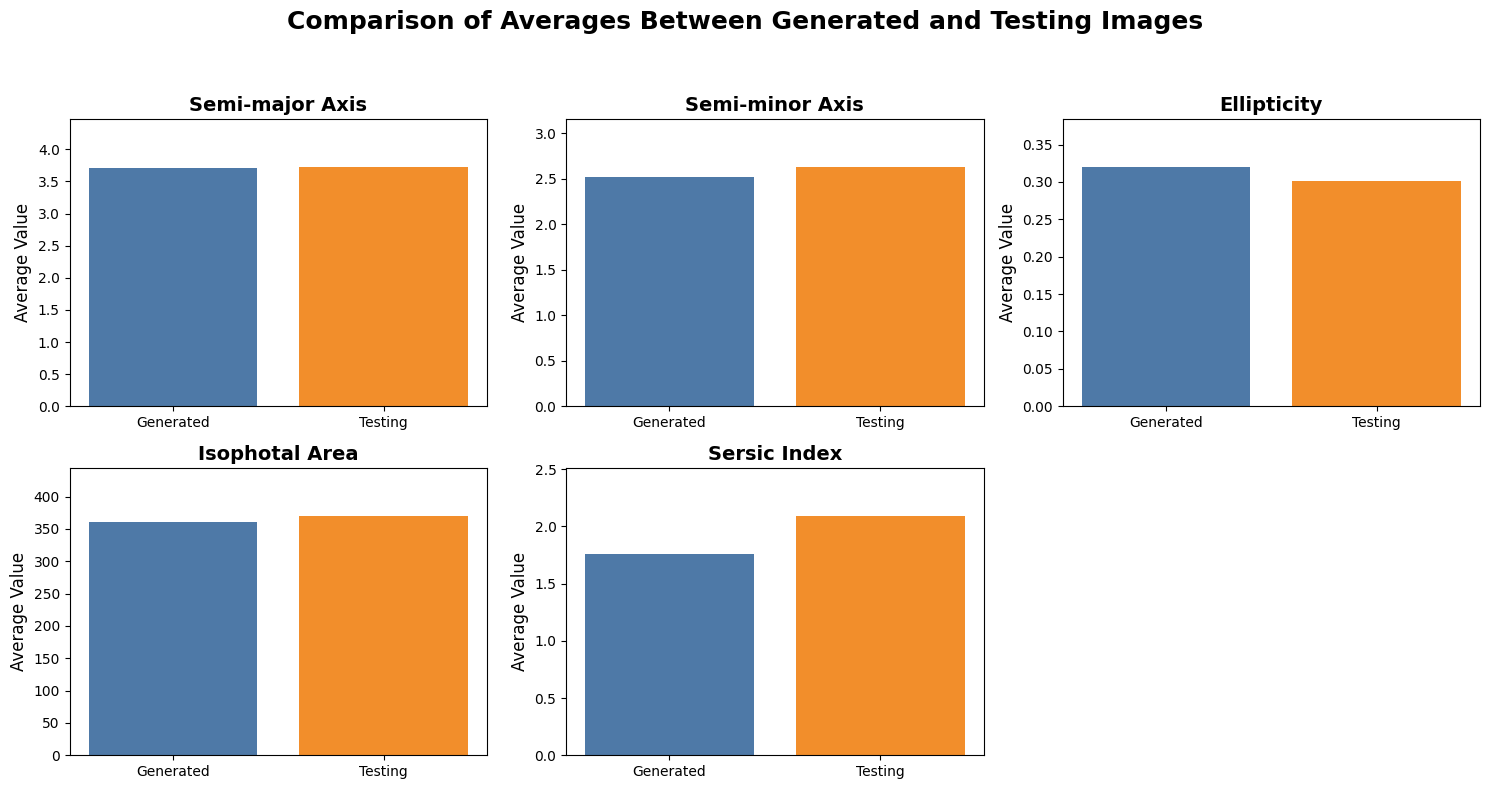

In [18]:
# Load averages from CSV for plotting
gen_averages, gen_orientation_avg = calculate_averages_from_csv('output/generated_images_metrics.csv')
test_averages, test_orientation_avg = calculate_averages_from_csv('output/testing_images_metrics.csv')

# Plotting the comparison of linear averages  
metrics = ['Semi-major Axis', 'Semi-minor Axis', 'Ellipticity', 'Isophotal Area', 'Sersic Index']
gen_avg_values = [gen_averages[metric] for metric in metrics]
test_avg_values = [test_averages[metric] for metric in metrics]

# Create a 2x3 grid for 5 metrics  
fig, axs = plt.subplots(2, 3, figsize=(15, 8))   
fig.patch.set_facecolor('white')   

# Define a color palette for the bars
colors = ['#4E79A7', '#F28E2B']  # Blue and orange tones 

# Plot each metric in a grid
for i, metric in enumerate(metrics):
    ax = axs[i // 3, i % 3]  # Determine subplot position
    ax.bar(['Generated', 'Testing'], [gen_avg_values[i], test_avg_values[i]], color=colors)
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Value', fontsize=12)
    ax.set_ylim([0, max(gen_avg_values[i], test_avg_values[i]) * 1.2])  # Dynamic y-axis limit for scaling

 
fig.delaxes(axs[1, 2])

# Add a main title and adjust layout
fig.suptitle('Comparison of Averages Between Generated and Testing Images', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.94])   
plt.show()

### Plotting Distribution Comparisons Between Testing and Generated Images

This code compares the distributions of key metrics between **testing** and **generated** images using kernel density estimation (KDE) plots.

- **Load Data:** The CSV files containing metrics for both testing and generated images are loaded into DataFrames.
- **Extract Metrics:** Specific metrics (`Semi-major Axis`, `Ellipticity`, `Sersic Index`, etc.) are extracted, dropping any `NaN` values to ensure clean data for plotting.
- **Plotting Function:** A function, `plot_distributions`, is defined to generate KDE plots for each metric, comparing the distributions of testing and generated images side by side.
  - The function takes in test and generated data, plots the KDEs, and visualizes how the distributions of these metrics differ between the two sets of images.


In [27]:
# Load the data from the CSV files
test_df = pd.read_csv('output/testing_images_metrics.csv')
gen_df = pd.read_csv('output/generated_images_metrics.csv')

# Extract the necessary data for plotting
test_semi_major_axes = test_df['Semi-major Axis'].dropna()
gen_semi_major_axes = gen_df['Semi-major Axis'].dropna()

test_semi_minor_axes = test_df['Semi-minor Axis'].dropna()
gen_semi_minor_axes = gen_df['Semi-minor Axis'].dropna()

test_ellipticities = test_df['Ellipticity'].dropna()
gen_ellipticities = gen_df['Ellipticity'].dropna()

test_orientation_angles = test_df['Orientation Angle'].dropna()
gen_orientation_angles = gen_df['Orientation Angle'].dropna()

test_isophotal_areas = test_df['Isophotal Area'].dropna()
gen_isophotal_areas = gen_df['Isophotal Area'].dropna()

test_sersic_indices = test_df['Sersic Index'].dropna()
gen_sersic_indices = gen_df['Sersic Index'].dropna()

# Function to plot general distributions
def plot_distributions(test_data, gen_data, label, xlabel):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(test_data, fill=True, label=f'Testing {label}', color='#FFA726', alpha=0.6)  # Orange for Testing
    sns.kdeplot(gen_data, fill=True, label=f'Generated {label}', color='#42A5F5', alpha=0.6)  # Blue for Generated
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(f'Distribution of {label} in Testing vs Generated Images')
    plt.legend()
    plt.show()

# Function to plot orientation angle density
def plot_orientation_density(test_orientation, gen_orientation):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(test_orientation, fill=True, color='#FFA726', label='Testing', alpha=0.6)  # Orange for Testing
    sns.kdeplot(gen_orientation, fill=True, color='#42A5F5', label='Generated', alpha=0.6)  # Blue for Generated
    plt.xlabel('Orientation Angle (radians)')
    plt.ylabel('Density')
    plt.title('Distribution of Orientation Angles in Testing vs Generated Images')
    plt.legend()
    plt.xlim(-np.pi/2, np.pi/2)  # Set x-axis to expected angle range
    plt.show()

### Plot distributions for various properties
Finally, we visualize the distributions of the semi-major axis, semi-minor axis, ellipticity, orientation angle, isophotal area, and Sersic index for both the testing and generated images.


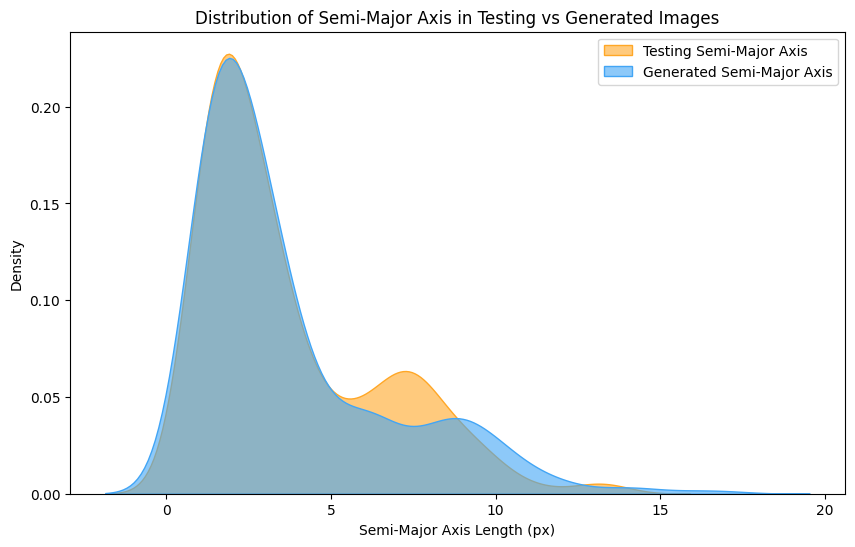

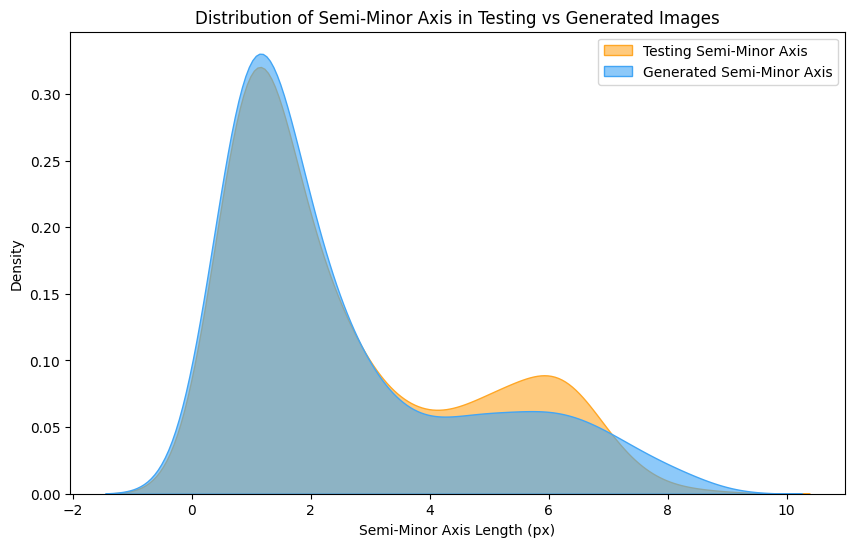

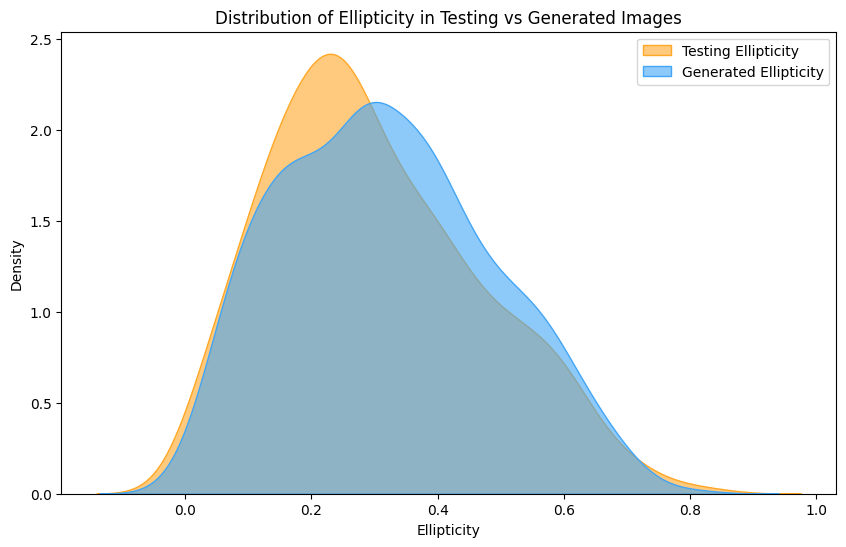

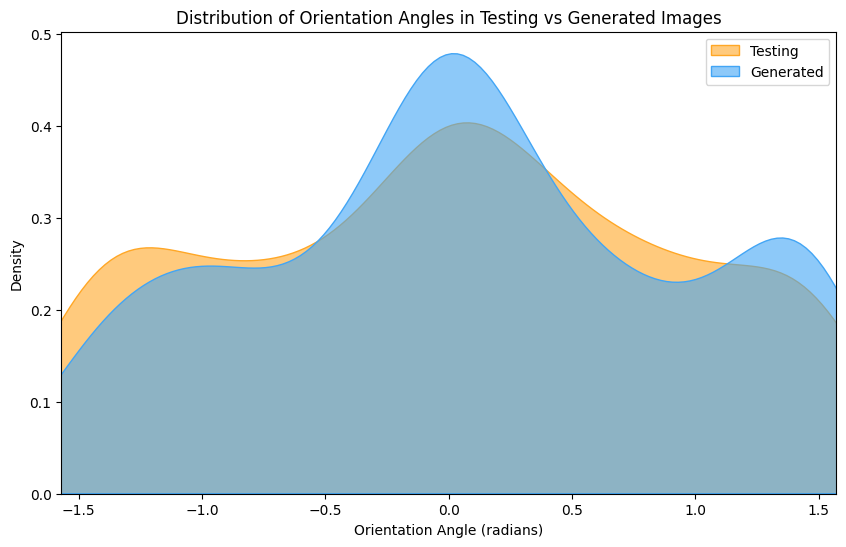

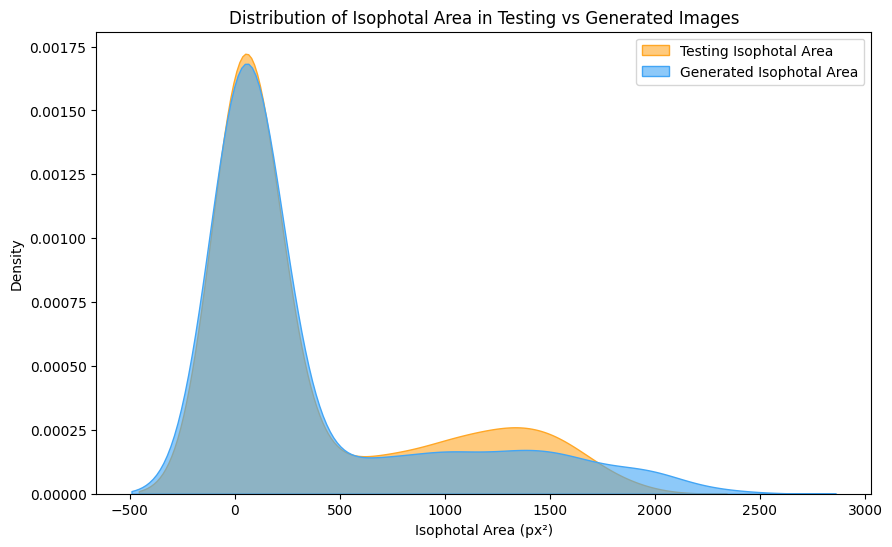

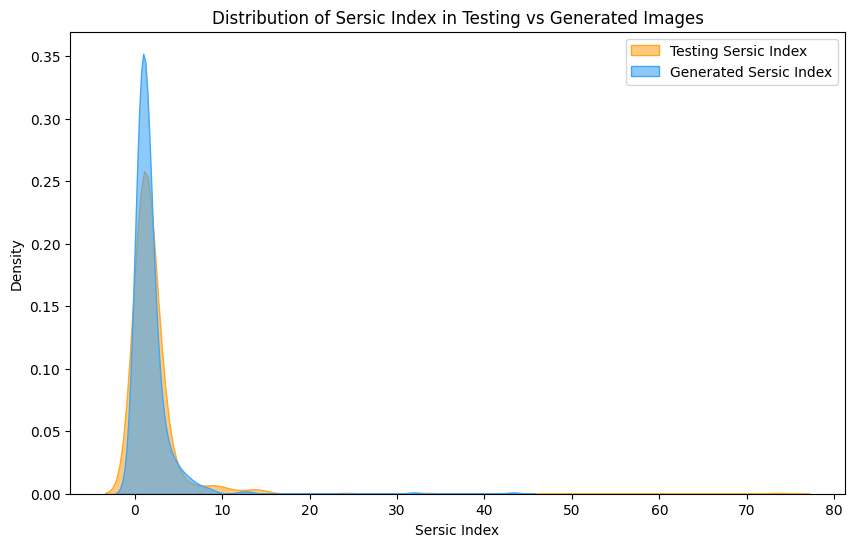

In [28]:
# Plot the distributions using the functions

# Semi-Major Axis Distribution
plot_distributions(
    test_semi_major_axes, gen_semi_major_axes,
    'Semi-Major Axis', 'Semi-Major Axis Length (px)'
)

# Semi-Minor Axis Distribution
plot_distributions(
    test_semi_minor_axes, gen_semi_minor_axes,
    'Semi-Minor Axis', 'Semi-Minor Axis Length (px)'
)

# Ellipticity Distribution
plot_distributions(
    test_ellipticities, gen_ellipticities,
    'Ellipticity', 'Ellipticity'
)

# Orientation Angle Distribution
# This plot specifically uses the plot_orientation_density function for orientation angles
plot_orientation_density(test_orientation_angles, gen_orientation_angles)

# Isophotal Area Distribution
plot_distributions(
    test_isophotal_areas, gen_isophotal_areas,
    'Isophotal Area', 'Isophotal Area (px²)'
)

# Sersic Index Distribution
plot_distributions(
    test_sersic_indices, gen_sersic_indices,
    'Sersic Index', 'Sersic Index'
)
